<a href="https://colab.research.google.com/github/itsmaul/bangkit-capstone/blob/main/Financial_Advice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CAPSTONE PROJECT - SELENA APP (SELLING, FINANCE, AND ANALYTICS)**

## **Proses Analisis oleh Model ML (Menggunakan File .pkl)**

1. Backend memuat model ML yang sudah dilatih (disimpan dalam format .pkl) menggunakan library Pickle di Python.
2. Model ML ini memproses data transaksi pengguna yang sudah diambil dari database untuk melakukan beberapa tugas analisis:
  - Deteksi Anomali Pengeluaran: Model ML mendeteksi adanya transaksi atau pengeluaran yang tidak biasa atau mencurigakan.
  - Arus Kas: Mengidentifikasi pola pemasukan dan pengeluaran.
  - Saran Keuangan: Berdasarkan analisis tren keuangan pengguna, model bisa memberikan saran, misalnya mengurangi pengeluaran di kategori tertentu.

## **Pengembalian Hasil Analisis ke Backend (ML ke CC)**

1. Model ML menghasilkan output analisis, seperti rekomendasi keuangan dan deteksi anomali, yang dikonversi ke format JSON.
2. Backend menerima hasil ini dan menggabungkannya menjadi satu respons JSON yang siap dikirim ke aplikasi mobile.

### **Import Library yang Digunakan**

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from matplotlib.dates import DateFormatter
from sklearn.preprocessing import MinMaxScaler

In [2]:
expense_df = pd.read_json('expense_data.json')

expense_df.head()

,date,amount
0,2023-08-03,20000
1,2023-08-08,186450
2,2023-08-12,384000
3,2023-08-12,400000
4,2023-08-14,150000


In [3]:
income_df = pd.read_json('income_data.json')

income_df.head()

,date,amount
0,2023-08-08,190000
1,2023-08-11,1200000
2,2023-09-01,1200000
3,2023-09-04,100000
4,2023-09-14,37000


## **TIME SERIES**

### **Function**

In [4]:
# Global Variables

SPLIT_TIME = 75
WINDOW_SIZE = 32
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 100

In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.subplots(figsize=(30, 6))
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
    plt.gcf().autofmt_xdate()
    plt.show()

In [6]:
def train_val_split(time, series):
    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]

    return time_train, series_train, time_valid, series_valid

In [7]:
def windowed_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)

    return dataset

In [8]:
def create_uncompiled_model():
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(WINDOW_SIZE, 1)),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu'),
        tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    return model

In [9]:
def create_model():

    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["mse"])

    return model

In [10]:
# Min-Max Scaler Initialization
scaler_expense = MinMaxScaler(feature_range=(0, 1))
scaler_income = MinMaxScaler(feature_range=(0, 1))

def preprocess_data(expense_df, income_df):
    # Rescaling data using MinMaxScaler
    expense_df['amount'] = scaler_expense.fit_transform(expense_df[['amount']])
    income_df['amount'] = scaler_income.fit_transform(income_df[['amount']])

    # Extract data from expense_df
    expense_dates = expense_df['date'].tolist()
    expenses = expense_df['amount'].tolist()

    # Extract data from income_df
    income_dates = income_df['date'].tolist()
    incomes = income_df['amount'].tolist()

    return expense_dates, expenses, income_dates, incomes


In [11]:
DATA_PATH = 'expense_data.json', 'income_data.json'

In [12]:
expense_dates, expenses, income_dates, incomes = preprocess_data(expense_df, income_df)

### **Plot Expense dan Income**

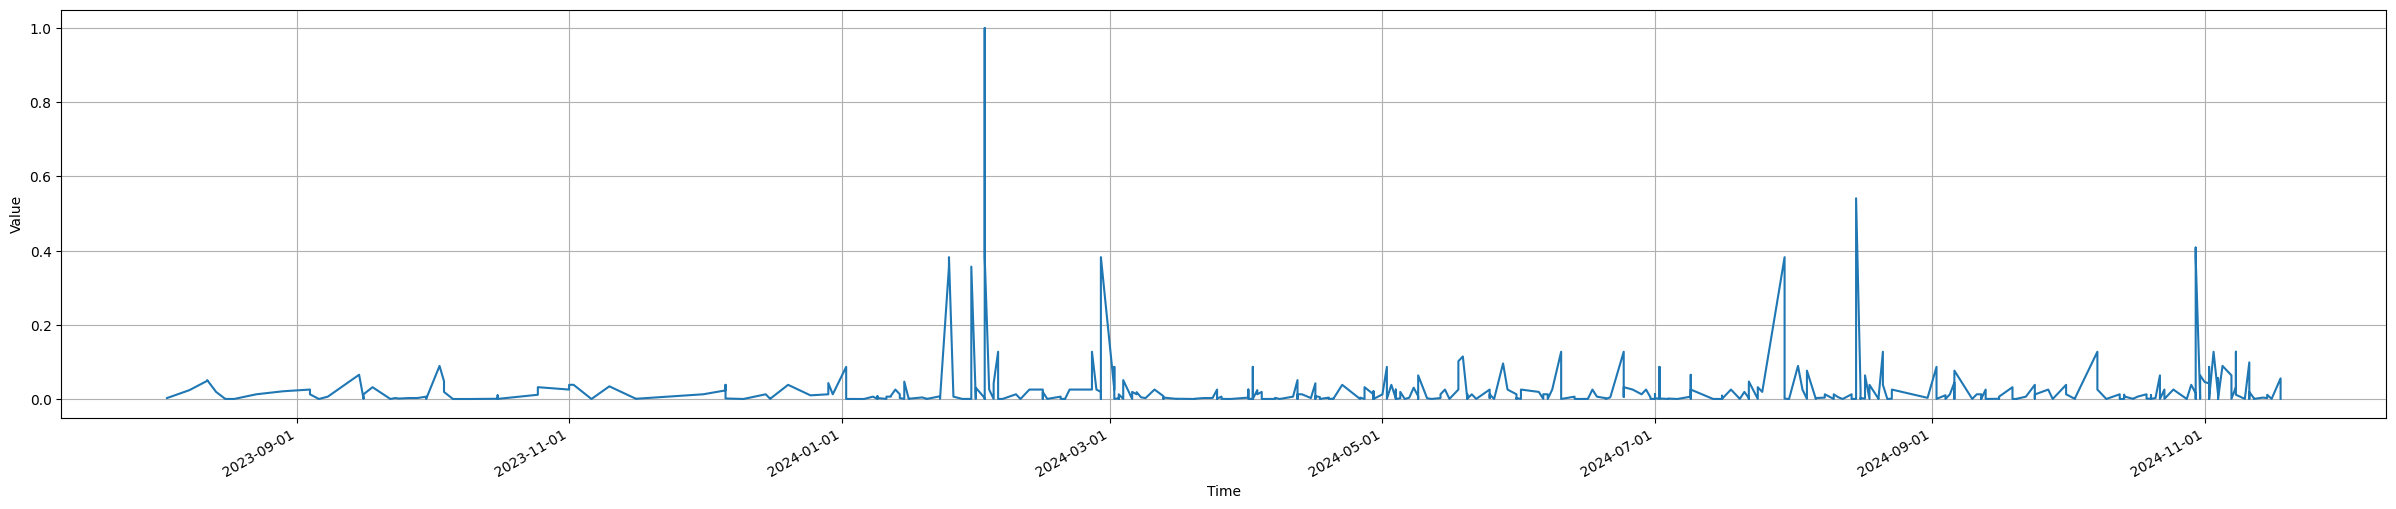

In [13]:
# Plot series
plot_series(expense_dates, expenses)

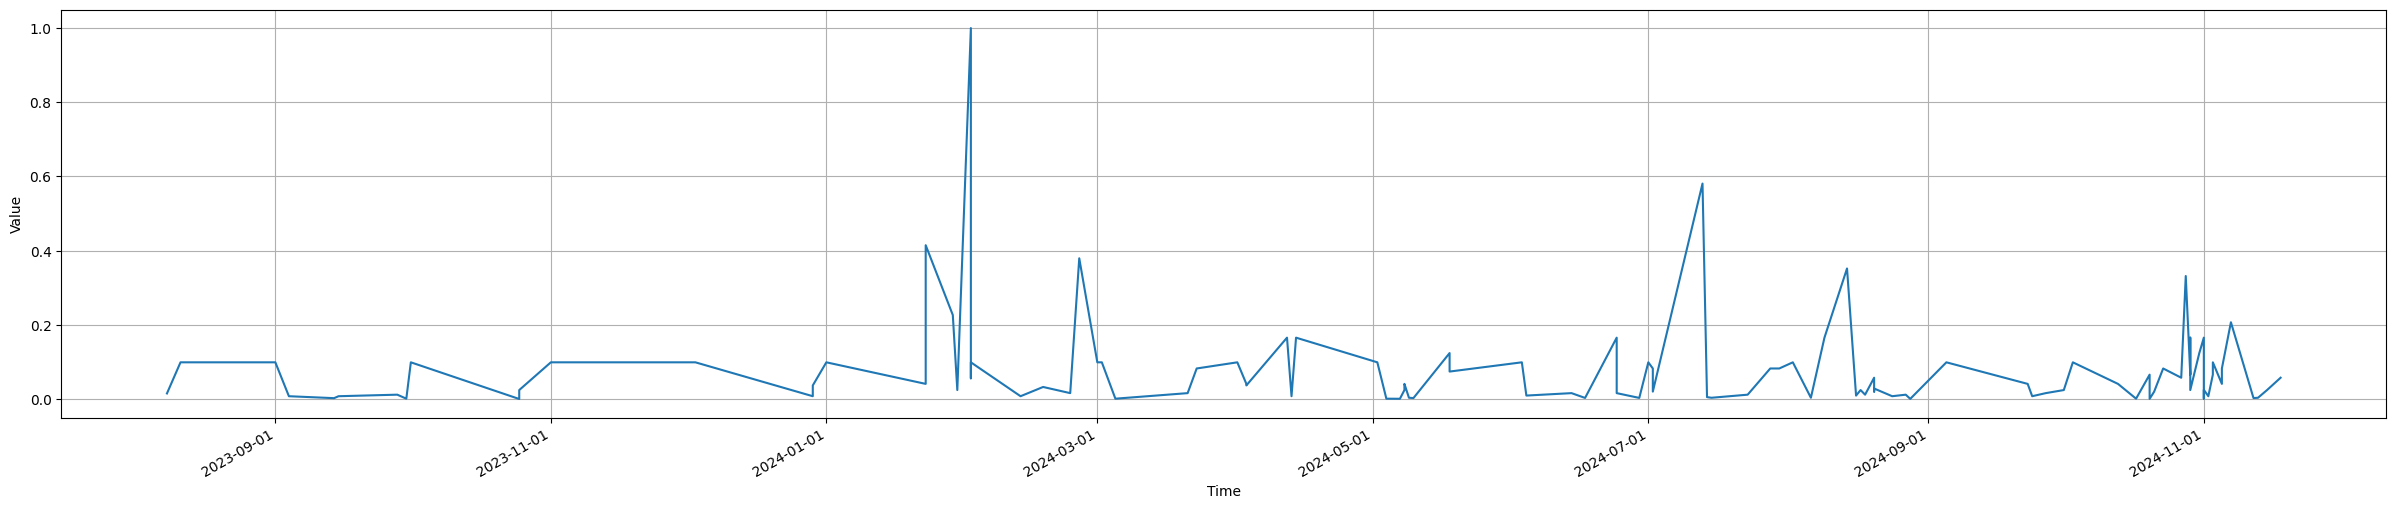

In [14]:
# Plot series
plot_series(income_dates, incomes)

In [15]:
# Split the expense dataset
time_train_expense, series_train_expense, time_valid_expense, series_valid_expense = train_val_split(expense_dates, expenses)

# Split the income dataset
time_train_income, series_train_income, time_valid_income, series_valid_income = train_val_split(income_dates, incomes)

In [16]:
train_dataset_expense = windowed_dataset(series_train_expense, window_size=WINDOW_SIZE)
train_dataset_income = windowed_dataset(series_train_income, window_size=WINDOW_SIZE)

#train_dataset = tf.data.Dataset.zip((train_dataset_expense, train_dataset_income))

In [17]:
valid_dataset_expense = windowed_dataset(series_valid_expense, window_size=WINDOW_SIZE)
valid_dataset_income = windowed_dataset(series_valid_income, window_size=WINDOW_SIZE)

#valid_dataset = tf.data.Dataset.zip((valid_dataset_expense, valid_dataset_income))

In [18]:
# Get your uncompiled model
uncompiled_model = create_uncompiled_model()

In [19]:
example_batch = train_dataset_expense.take(1)

try:
	predictions = uncompiled_model.predict(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	print("Your current architecture is compatible with the windowed dataset! :)")
	print(f"predictions have shape: {predictions.shape}")

Your current architecture is compatible with the windowed dataset! :)
predictions have shape: (43, 32, 1)


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [20]:
uncompiled_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 32, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32, 128)             │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32, 128)             │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32, 1)               │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 107,393 (419.50 KB)

 Trainable params: 107,393 (419.50 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model = create_model()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 100))

history = model.fit(train_dataset_expense, validation_data=valid_dataset_expense, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 2.8824e-04 - mse: 5.7647e-04 - val_loss: 0.0020 - val_mse: 0.0040 - learning_rate: 1.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - loss: 2.5767e-04 - mse: 5.1534e-04 - val_loss: 0.0020 - val_mse: 0.0040 - learning_rate: 1.0233e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - loss: 2.4184e-04 - mse: 4.8369e-04 - val_loss: 0.0019 - val_mse: 0.0039 - learning_rate: 1.0471e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - loss: 2.2623e-04 - mse: 4.5247e-04 - val_loss: 0.0019 - val_mse: 0.0038 - learning_rate: 1.0715e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - loss: 2.1099e-04 - mse: 4.2198e-04 - val_loss: 0.0019 - val_mse: 0.0038 - learning_rate: 1.0965e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 1.9854e-04 - mse: 3.9707e-04 - val_loss: 0.0019 - val_mse: 0.0037 - learning_rate: 1.1220e-04
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - loss: 1.8710e-04 - mse: 3.7420e-

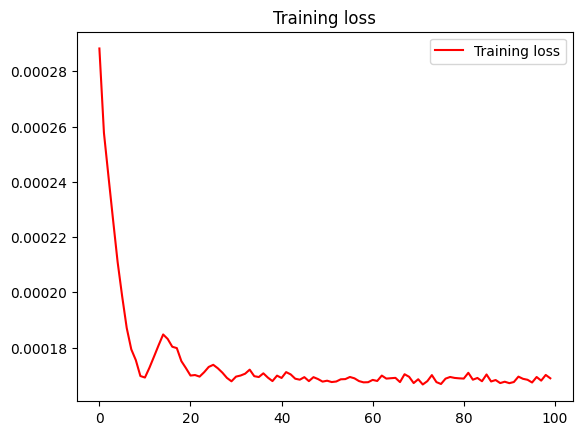

In [22]:
# Plot the training loss for each epoch

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

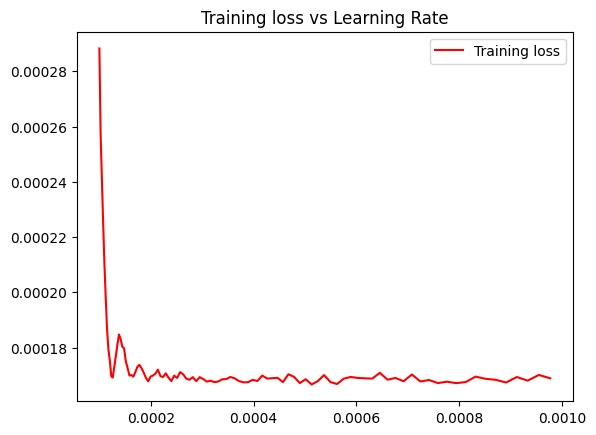

In [23]:
# Plot the training loss for each learning rate

lr = history.history['learning_rate']

plt.plot(lr, loss, 'r', label='Training loss')
plt.title('Training loss vs Learning Rate')
plt.legend(loc=0)
plt.show()

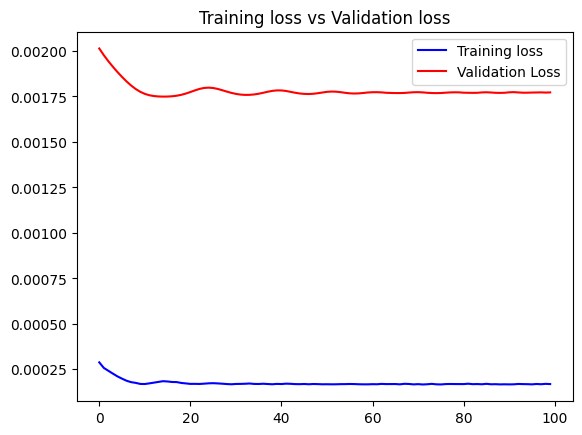

In [24]:
# Plot the training loss for each learning rate

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training loss vs Validation loss')
plt.legend()
plt.show()

### **Evaluate Forecast**

In [25]:
def compute_metrics(true_series, forecast):
    """Computes MSE and MAE metrics for the forecast"""
    mse = tf.keras.losses.MSE(true_series, forecast)
    mae = tf.keras.losses.MAE(true_series, forecast)
    return mse, mae

In [26]:
def model_forecast(model, series, window_size):
    """Generates a forecast using your trained model"""
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast[:,-1]

In [27]:
# Compute the forecast for the validation dataset. Remember you need the last WINDOW SIZE values to make the first prediction
rnn_forecast = model_forecast(model, series_valid_expense[SPLIT_TIME-WINDOW_SIZE:-1], WINDOW_SIZE).squeeze()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


<Figure size 3000x600 with 0 Axes>

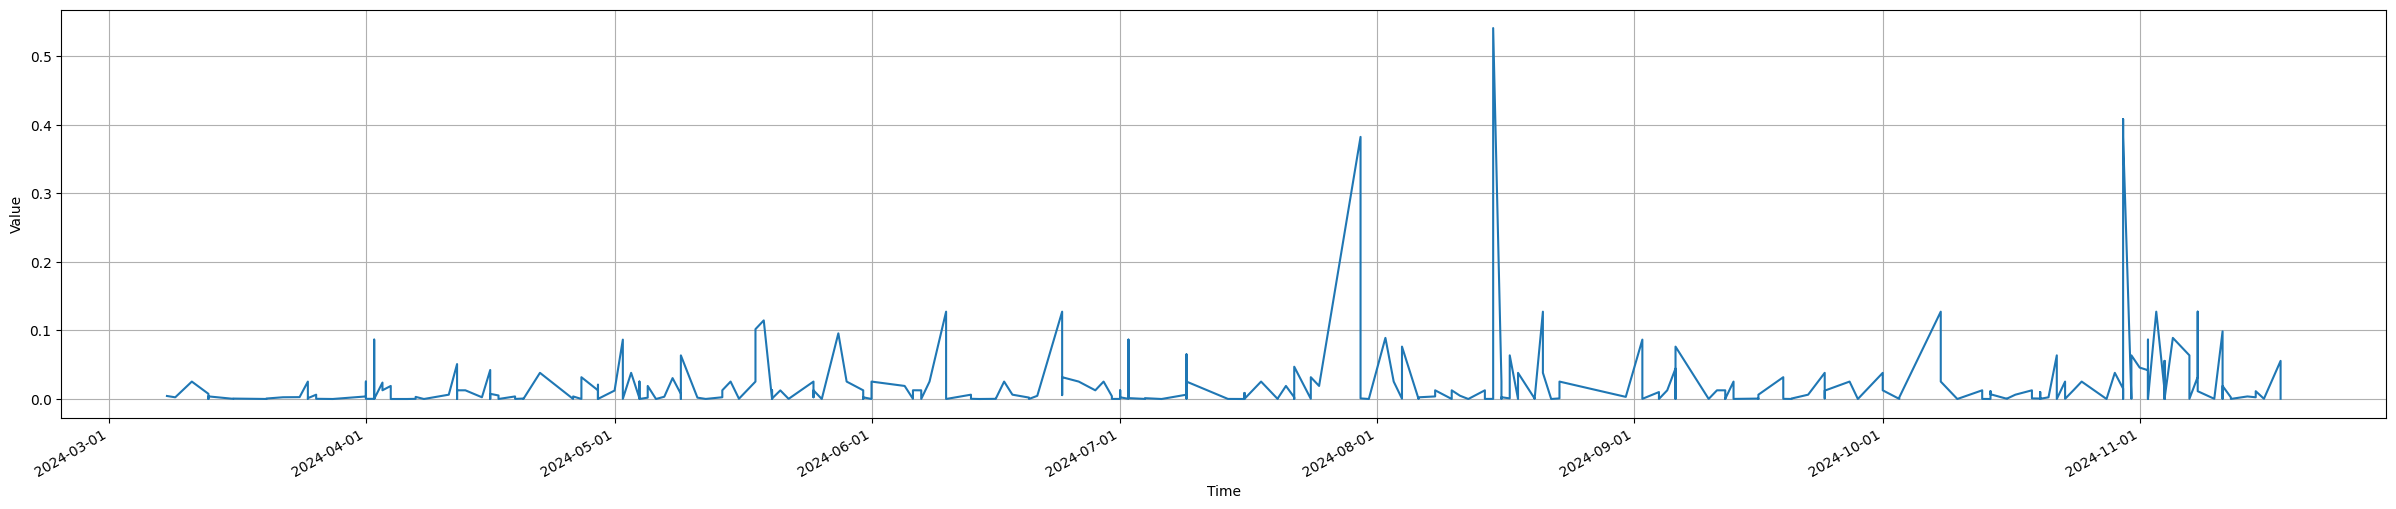

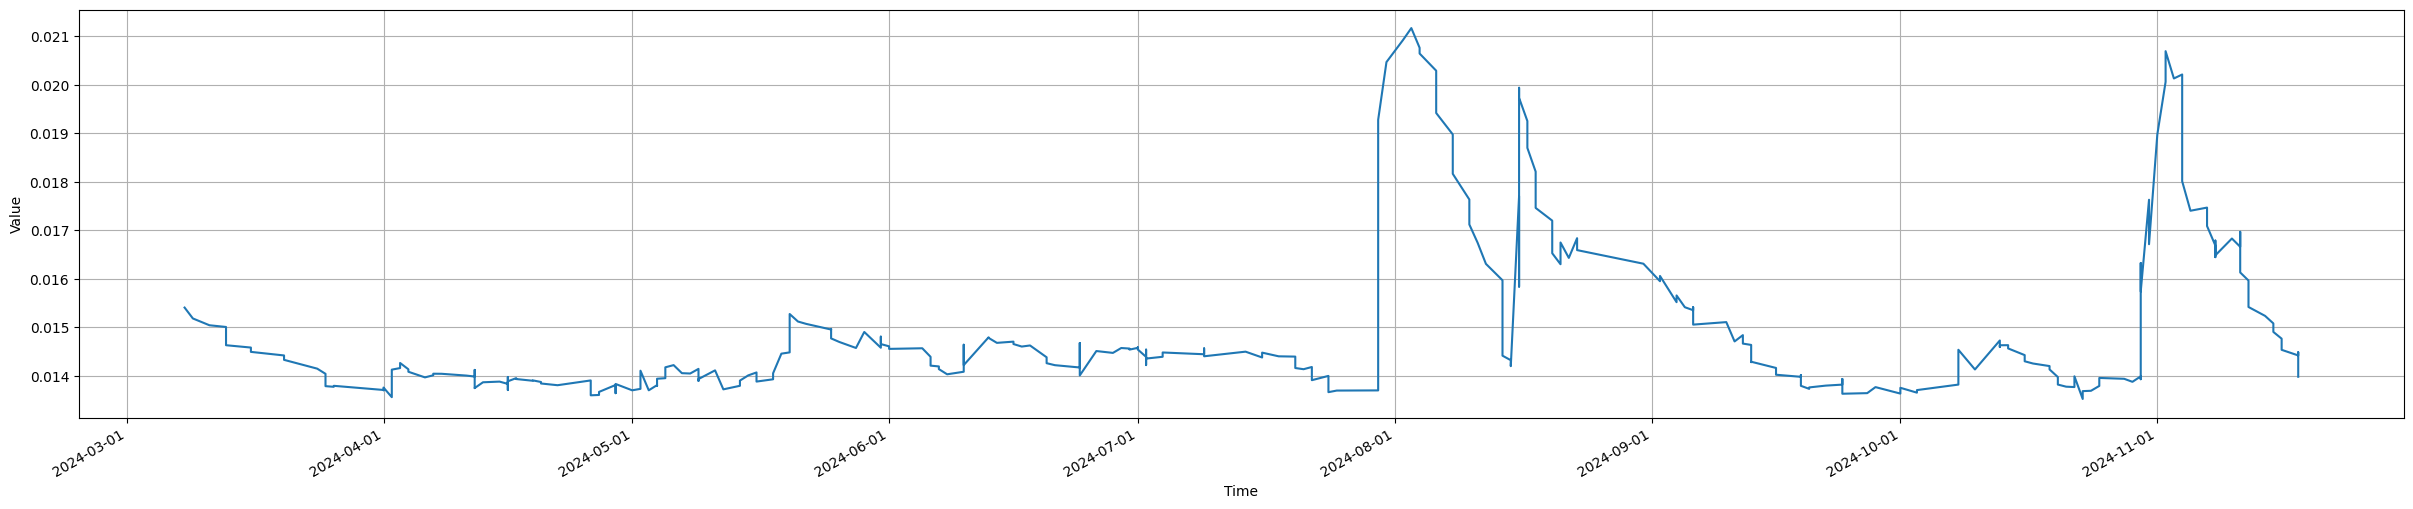

In [28]:
# Plot the forecast
plt.figure(figsize=(30, 6))

plot_series(time_valid_expense[-(len(rnn_forecast)):], series_valid_expense[-(len(rnn_forecast)):])
plot_series(time_valid_expense[-(len(rnn_forecast)):], rnn_forecast)

In [29]:
mse, mae = compute_metrics(series_valid_expense[-(len(rnn_forecast)):], rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 0.00, mae: 0.02 for forecast


In [30]:
# """ # Save metrics into a dictionary
# metrics_dict = {
#     "mse": float(mse),
#     "mae": float(mae)
# }

# # Save your metrics in a binary file
# with open('metrics.pkl', 'wb') as f:
#     pickle.dump(metrics_dict, f)